In [1]:
import numpy as np 
#from pyuoi.linear_model import UoILasso
import os, sys
sys.path.append('..')
from utils import gen_covariance, gen_beta2, gen_data, selection_accuracy, FNR, FPR

In [2]:
import pdb
import time
import matplotlib.pyplot as plt

In [3]:
from pyuoi.linear_model import UoI_Lasso

In [4]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.model_selection import train_test_split

In [5]:
def empirical_model_loss(y, y_pred, M, penalty):
    n_samples = y.size
    rss = (y.ravel() - y_pred.ravel())**2
    if penalty == 'AICc':
        model_size_penalty = 2 * M + (2 * M**2 + 2 * M)/(n_samples - M - 1)
    else:
        model_size_penalty = penalty * M
    
    llhood = n_samples/2 * (1 + np.log(np.mean(rss)))
    return 2 * llhood + model_size_penalty, 2 * llhood, model_size_penalty

In [24]:
# Compare with Lasso, iterate over the estimation frac - test using both the training data and the test data
# in scoring. Is there a scenario in which the 

n_samples = 500
n_features = 100

n_reps = 10

estimation_fracs = [0.9, 0.8, 0.7, 0.6]

sparsity = np.linspace(0.05, 1, 10)

sa = np.zeros((len(sparsity), len(estimation_fracs), 2))
r2_score = np.zeros(sa.shape)
fnr =  np.zeros(r2_score.shape)
fpr = np.zeros(fnr.shape)
MSE = np.zeros(fpr.shape)

lasso = LassoCV(n_alphas = 48, cv = 10)

# Iterate over sparsities
for i, s in enumerate(sparsity):
    t0 = time.time()
       
    sigma = gen_covariance(n_features, 0, n_features, 1, 0)
    beta = gen_beta2(n_features, n_features, sparsity = s)
    X, X_test, y, y_test, sigma_sq = gen_data(n_samples, n_features, covariance = sigma, 
                                              beta = beta)            
    lasso_coefs = np.zeros((n_reps, n_features))

    for rep in np.arange(n_reps):
        lasso.fit(X, y.ravel())
        lasso_coefs[rep, :] = lasso.coef_
        r2_score[i, 0, 1] += 1/n_reps * lasso.score(X_test, y_test)
        MSE[i, 0, 1] += 1/n_reps * mean_squared_error(y_test, lasso.predict(X_test))
    
    sa[i, 0, 1] = np.mean(selection_accuracy(beta.ravel(), lasso_coefs))
    fnr[i, 0, 1] = np.mean(FNR(beta.ravel(), lasso_coefs))
    fpr[i, 0, 1] = np.mean(FPR(beta.ravel(), lasso_coefs))
                
    for j, estimation_frac in enumerate(estimation_fracs):

        uoil = UoI_Lasso(n_boots_sel = 48, stability_selection = 1., n_lambdas = 48,
                         estimation_score = 'AIC', n_boots_est = 48, estimation_frac = estimation_frac)

        uoil_coefs = np.zeros((n_reps, n_features))
        for rep in np.arange(n_reps): 
            uoil.fit(X, y.ravel())
            uoil_coefs[rep, :] = uoil.coef_
            r2_score[i, j, 0] += 1/n_reps * uoil.score(X_test, y_test)
            MSE[i, j, 0] += 1/n_reps * mean_squared_error(y_test, uoil.predict(X_test))
        
        sa[i, j, 0] = np.mean(selection_accuracy(beta.ravel(), uoil_coefs))
        fnr[i, j, 0] = np.mean(FNR(beta.ravel(), uoil_coefs))
        fpr[i, j, 0] = np.mean(FPR(beta.ravel(), uoil_coefs))
            
    print(time.time() - t0)

99.81292748451233
107.93472480773926
121.76803207397461
135.49512338638306
138.89741277694702
137.86607384681702
138.35843110084534
140.76943826675415
145.05706596374512
144.38962936401367


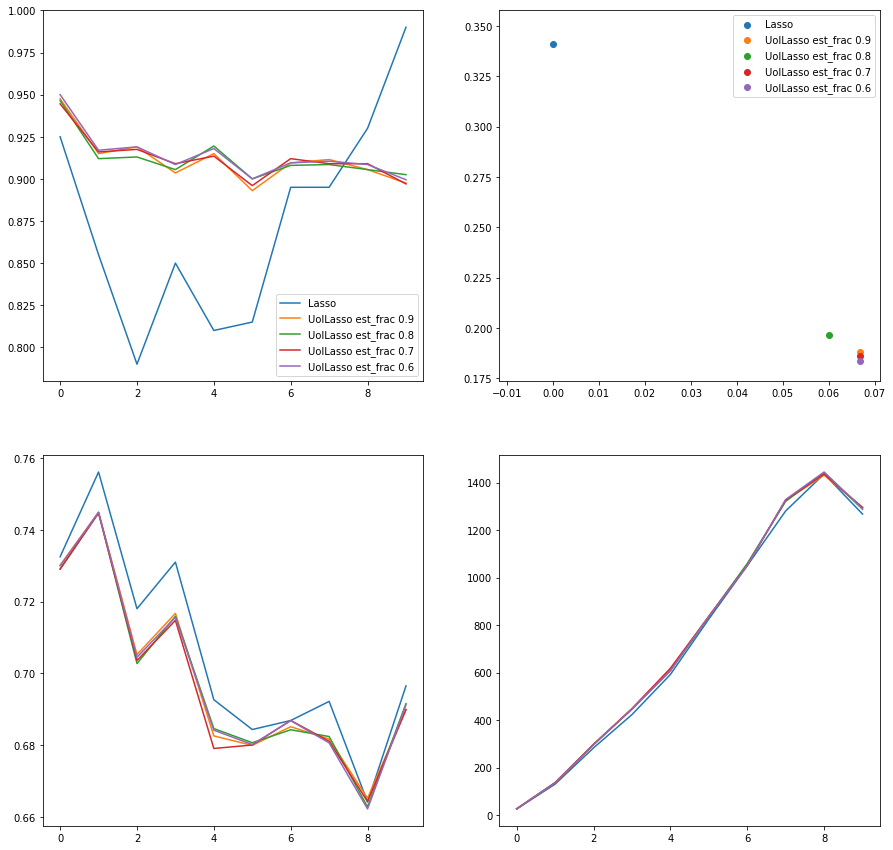

In [25]:
# Plot selection accuracy of Lasso and selection accuracy for each estimation frac of UoI Lasso
# Plot FNR vs. FPR
# Plot r^2
# Plot MSE
fig, ax = plt.subplots(2, 2, figsize = (15, 15))

ax[0, 0].plot(sa[:, 0, 1])
for i in range(len(estimation_fracs)):
    ax[0, 0].plot(sa[:, i, 0])
ax[0, 0].legend(['Lasso', 'UoILasso est_frac 0.9', 'UoILasso est_frac 0.8', 
                 'UoILasso est_frac 0.7', 'UoILasso est_frac 0.6'])
            
ax[0, 1].scatter(fnr[1, 0, 1], fpr[1, 0, 1])
for i in range(len(estimation_fracs)):
    ax[0, 1].scatter(fnr[1, i, 0], fpr[1, i, 0])
ax[0, 1].legend(['Lasso', 'UoILasso est_frac 0.9', 'UoILasso est_frac 0.8', 
                 'UoILasso est_frac 0.7', 'UoILasso est_frac 0.6'])

ax[1, 0].plot(r2_score[:, 0, 1])
for i in range(len(estimation_fracs)):
    ax[1, 0].plot(r2_score[:, i, 0])

    
ax[1, 1].plot(MSE[:, 0, 1])
for i in range(len(estimation_fracs)):
    ax[1, 1].plot(MSE[:, i, 0])


In [6]:
# Estimation frac does not make a difference, apparently. Repeat the same process, but now use 100 features and
# vary the number of samples instead

n_samples_ = [100, 200, 300, 400, 500]
n_features = 100

n_reps = 10

estimation_frac = 0.9

sparsity = np.linspace(0.05, 1, 10)

sa = np.zeros((len(sparsity), len(n_samples_), 2))
r2_score = np.zeros(sa.shape)
fnr =  np.zeros(r2_score.shape)
fpr = np.zeros(fnr.shape)
MSE = np.zeros(fpr.shape)

lasso = LassoCV(n_alphas = 48, cv = 10)

# Iterate over sparsities
for i, s in enumerate(sparsity):
    t0 = time.time()

    for j, n_samples in enumerate(n_samples_):


        sigma = gen_covariance(n_features, 0, n_features, 1, 0)
        beta = gen_beta2(n_features, n_features, sparsity = s)
        X, X_test, y, y_test, sigma_sq = gen_data(n_samples, n_features, covariance = sigma, 
                                                  beta = beta)            
        lasso_coefs = np.zeros((n_reps, n_features))

        for rep in np.arange(n_reps):
            lasso.fit(X, y.ravel())
            lasso_coefs[rep, :] = lasso.coef_
            r2_score[i, j, 1] += 1/n_reps * lasso.score(X_test, y_test)
            MSE[i, j, 1] += 1/n_reps * mean_squared_error(y_test, lasso.predict(X_test))

        sa[i, j, 1] = np.mean(selection_accuracy(beta.ravel(), lasso_coefs))
        fnr[i, j, 1] = np.mean(FNR(beta.ravel(), lasso_coefs))
        fpr[i, j, 1] = np.mean(FPR(beta.ravel(), lasso_coefs))


        uoil = UoI_Lasso(n_boots_sel = 48, stability_selection = 1., n_lambdas = 48,
                         estimation_score = 'AIC', n_boots_est = 48, estimation_frac = estimation_frac)

        uoil_coefs = np.zeros((n_reps, n_features))
        for rep in np.arange(n_reps): 
            uoil.fit(X, y.ravel())
            uoil_coefs[rep, :] = uoil.coef_
            r2_score[i, j, 0] += 1/n_reps * uoil.score(X_test, y_test)
            MSE[i, j, 0] += 1/n_reps * mean_squared_error(y_test, uoil.predict(X_test))

        sa[i, j, 0] = np.mean(selection_accuracy(beta.ravel(), uoil_coefs))
        fnr[i, j, 0] = np.mean(FNR(beta.ravel(), uoil_coefs))
        fpr[i, j, 0] = np.mean(FPR(beta.ravel(), uoil_coefs))
            
    print(time.time() - t0)

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

139.54255723953247


/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

149.59957766532898


/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

162.39570832252502


/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

169.79358458518982


/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

164.35584831237793


/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


183.36862301826477


/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

178.69820070266724


/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

174.2693874835968


/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

169.79290914535522


/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

180.2823417186737


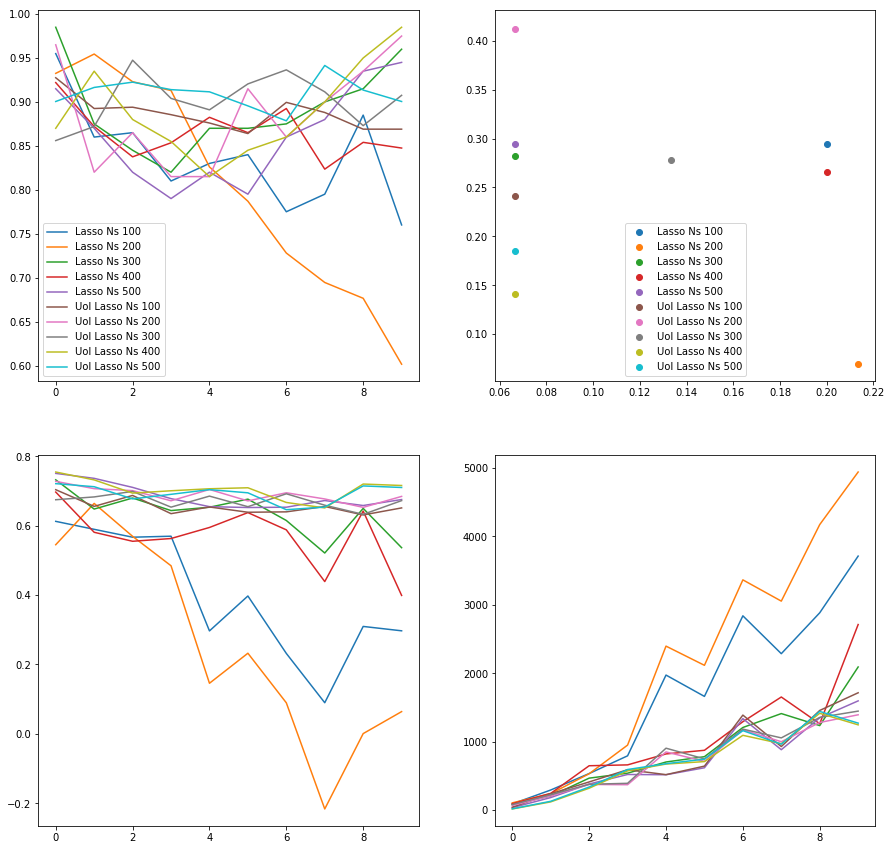

In [7]:
# Plot selection accuracy of Lasso and selection accuracy for each estimation frac of UoI Lasso
# Plot FNR vs. FPR
# Plot r^2
# Plot MSE
fig, ax = plt.subplots(2, 2, figsize = (15, 15))

for i in range(len(n_samples_)):
    ax[0, 0].plot(sa[:, i, 1])
    ax[0, 0].plot(sa[:, i, 0])
legend_str = ['Lasso Ns %d' % n_samples for n_samples in n_samples_]
legend_str.extend(['UoI Lasso Ns %d' % n_samples for n_samples in n_samples_])
ax[0, 0].legend(legend_str)

for i in range(len(n_samples_)):
    ax[0, 1].scatter(fnr[1, i, 1], fpr[1, i, 1])
    ax[0, 1].scatter(fnr[1, i, 0], fpr[1, i, 0])
ax[0, 1].legend(legend_str)
    
for i in range(len(n_samples_)):
    ax[1, 0].plot(r2_score[:, i, 1])
    ax[1, 0].plot(r2_score[:, i, 0])
    
for i in range(len(n_samples_)):
    ax[1, 1].plot(MSE[:, i, 1])
    ax[1, 1].plot(MSE[:, i, 0])


In [ ]:
# Can we explain what is going on with high feature counts? Is there a qualitative difference in the behavior 
# of AIC as the candidate model dimensions increase?

n_samples_ = [2500]
n_features = 500

n_reps = 5

estimation_frac = 0.9

sparsity = np.linspace(0.05, 1, 10)

sa = np.zeros((len(sparsity), len(n_samples_), 2))
r2_score = np.zeros(sa.shape)
fnr =  np.zeros(r2_score.shape)
fpr = np.zeros(fnr.shape)
MSE = np.zeros(fpr.shape)

lasso = LassoCV(n_alphas = 48, cv = 10)

# Iterate over sparsities
for i, s in enumerate(sparsity):
    t0 = time.time()

    for j, n_samples in enumerate(n_samples_):


        sigma = gen_covariance(n_features, 0, n_features, 1, 0)
        beta = gen_beta2(n_features, n_features, sparsity = s)
        X, X_test, y, y_test, sigma_sq = gen_data(n_samples, n_features, covariance = sigma, 
                                                  beta = beta)            
        lasso_coefs = np.zeros((n_reps, n_features))

        for rep in np.arange(n_reps):
            lasso.fit(X, y.ravel())
            lasso_coefs[rep, :] = lasso.coef_
            r2_score[i, j, 1] += 1/n_reps * lasso.score(X_test, y_test)
            MSE[i, j, 1] += 1/n_reps * mean_squared_error(y_test, lasso.predict(X_test))

        sa[i, j, 1] = np.mean(selection_accuracy(beta.ravel(), lasso_coefs))
        fnr[i, j, 1] = np.mean(FNR(beta.ravel(), lasso_coefs))
        fpr[i, j, 1] = np.mean(FPR(beta.ravel(), lasso_coefs))


        uoil = UoI_Lasso(n_boots_sel = 48, stability_selection = 1., n_lambdas = 48,
                         estimation_score = 'AIC', n_boots_est = 48, estimation_frac = estimation_frac)

        uoil_coefs = np.zeros((n_reps, n_features))
        for rep in np.arange(n_reps): 
            uoil.fit(X, y.ravel())
            uoil_coefs[rep, :] = uoil.coef_
            r2_score[i, j, 0] += 1/n_reps * uoil.score(X_test, y_test)
            MSE[i, j, 0] += 1/n_reps * mean_squared_error(y_test, uoil.predict(X_test))

        sa[i, j, 0] = np.mean(selection_accuracy(beta.ravel(), uoil_coefs))
        fnr[i, j, 0] = np.mean(FNR(beta.ravel(), uoil_coefs))
        fpr[i, j, 0] = np.mean(FPR(beta.ravel(), uoil_coefs))
            
    print(time.time() - t0)

325.35119009017944
352.832377910614
378.16930747032166
422.5828607082367
459.79428720474243
526.7405376434326
524.4382610321045
552.5533354282379
546.260240316391
